# imports

In [1]:
!pip install torchmetrics[detection] -q
!pip install torchmetrics -q

In [2]:
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import cv2

import torch
from torch.utils.data import Dataset, DataLoader
from torch.amp import GradScaler, autocast
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from sklearn.model_selection import KFold, train_test_split

import albumentations as A
from albumentations.pytorch import ToTensorV2

from torchmetrics.detection.mean_ap import MeanAveragePrecision
from tqdm import tqdm
import random

/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
torch.manual_seed(3)
torch.cuda.manual_seed(3)
torch.cuda.manual_seed_all(3)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(3)
random.seed(3)

In [4]:
PATH = '/kaggle/input/ghana-crop-disease/'
IMG_PATH = '/kaggle/input/ghana-crop-disease/images/'

# Helper Function

In [5]:
def visualize_sample(image_id, dataframe):
    image_path = os.path.join(IMG_PATH, f"{image_id}")
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    rows = dataframe[dataframe["Image_ID"] == image_id]
    for _, row in rows.iterrows():
        ymin, xmin, ymax, xmax = int(row['ymin']), int(row['xmin']), int(row['ymax']), int(row['xmax'])
        label = row['class']
        confidence = row['confidence']

        # Draw bounding box
        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
        cv2.putText(image, f"{label} ({confidence:.2f})", (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis("off")
    plt.show()

In [6]:
def get_model(num_classes):
    """
    Load a pre-trained Faster R-CNN model and modify it for our dataset.

    Args:
        num_classes (int): Number of classes (including background class).

    Returns:
        model (nn.Module): Modified Faster R-CNN model.
    """

    # Load pre-trained Faster R-CNN model
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='FasterRCNN_ResNet50_FPN_Weights.COCO_V1')
    # Get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # Replace the classifier with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

# Data Loading

## Loading the CSV

In [7]:
train = pd.read_csv(f"{PATH}Train.csv")
test = pd.read_csv(f"{PATH}Test.csv")
ss = pd.read_csv(f"{PATH}SampleSubmission.csv")

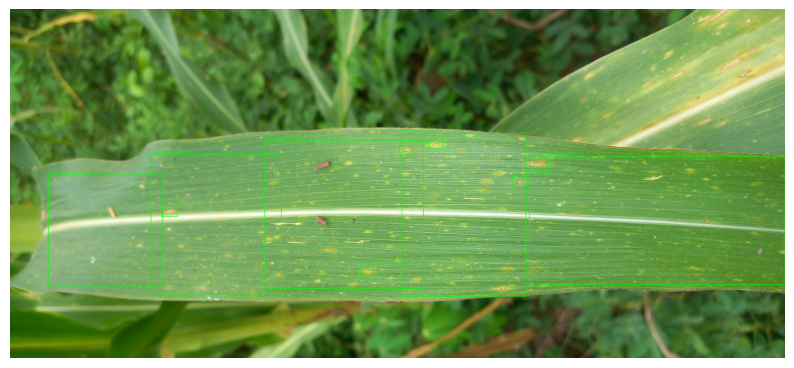

In [8]:
sample_image_id = train["Image_ID"].iloc[7]
visualize_sample(sample_image_id, train)

In [9]:
label_mapping = {label: idx+1 for idx, label in enumerate(train["class"].unique())}
reverse_label_mapping = {idx: label for label, idx in label_mapping.items()}
print("Label Mapping:", label_mapping)

Label Mapping: {'Pepper_Bacterial_Spot': 1, 'Pepper_Fusarium': 2, 'Corn_Cercospora_Leaf_Spot': 3, 'Corn_Common_Rust': 4, 'Tomato_Early_Blight': 5, 'Pepper_Septoria': 6, 'Tomato_Septoria': 7, 'Pepper_Leaf_Curl': 8, 'Pepper_Leaf_Mosaic': 9, 'Corn_Streak': 10, 'Corn_Healthy': 11, 'Pepper_Healthy': 12, 'Tomato_Healthy': 13, 'Pepper_Late_Blight': 14, 'Tomato_Late_Blight': 15, 'Pepper_Cercospora': 16, 'Tomato_Fusarium': 17, 'Pepper_Leaf_Blight': 18, 'Tomato_Leaf_Curl': 19, 'Tomato_Bacterial_Spot': 20, 'Tomato_Mosaic': 21, 'Pepper_Early_Blight': 22, 'Corn_Northern_Leaf_Blight': 23}


In [10]:
train["class_id"] = train["class"].map(label_mapping)

In [11]:
#train_images, val_images = train_test_split(train["Image_ID"].unique(), test_size=0.2, random_state=42)
#train_data = train[train["Image_ID"].isin(train_images)]
#val_data = train[train["Image_ID"].isin(val_images)]

In [12]:
def get_train_transform():
    return A.Compose(
        [
            A.Resize(512, 512),
            A.OneOf(
                [
                    A.RandomBrightnessContrast(p=0.3),  # Brightness/contrast adjustment
                    A.Rotate(limit=45, p=0.3),         # Random rotation
                    A.ElasticTransform(alpha=120, sigma=120 * 0.05, p=0.3),
                ],
                p=0.4,
            ),
            A.HorizontalFlip(p=0.6),
            A.VerticalFlip(p=0.6),
            ToTensorV2(p=1.0),
        ],
        bbox_params=A.BboxParams(
            format='pascal_voc',  # Ensure pascal_voc format
            min_area=1,
            label_fields=['labels']
        ),
    )
def get_valid_transform():
    return A.Compose(
        [
            ToTensorV2(p=1.0),
        ],
        bbox_params=A.BboxParams(
            format='pascal_voc',  # Ensure pascal_voc format
            min_area=1,
            label_fields=['labels']
        ),
    )

## Model data preparation

In [13]:
class CropDiseaseDataset(Dataset):
    def __init__(self, dataframe, image_dir, transforms=None):
        """
        Initialize the dataset.

        Args:
        - dataframe: DataFrame containing annotations.
        - image_dir: Directory path for images.
        - transforms: Albumentations transforms to apply to the images and bounding boxes.
        """
        super().__init__()
        self.image_ids = dataframe['Image_ID'].unique()  # Unique image IDs
        self.df = dataframe  # Full DataFrame
        self.image_dir = image_dir  # Path to the images
        self.transforms = transforms  # Transformations to apply

    def __getitem__(self, index: int):
        """
        Fetch a data sample at a given index.

        Args:
        - index: Index of the sample.

        Returns:
        - image: Transformed image tensor.
        - target: Dictionary with bounding box data and metadata.
        - image_id: Unique identifier for the image.
        """
        image_id = self.image_ids[index]
        records = self.df[self.df['Image_ID'] == image_id]

        # Load and preprocess the image
        image = cv2.imread(f'{self.image_dir}{image_id}', cv2.IMREAD_COLOR)  # Load image
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)  # Convert to RGB
        image /= 255.0  # Normalize to [0, 1]
        height, width, _ = image.shape

        # Get bounding box coordinates and ensure they are valid
        boxes = records[['xmin', 'ymin', 'xmax', 'ymax']].values
        if ((boxes[:, 2] - boxes[:, 0]) <= 0).any() or ((boxes[:, 3] - boxes[:, 1]) <= 0).any():
            return self.__getitem__(np.random.randint(len(self)))  # Skip invalid boxes

        # Calculate the area of each bounding box
        area = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])
        area = torch.as_tensor(area, dtype=torch.float32)

        # Get class labels
        labels = records['class_id'].values
        labels = torch.as_tensor(labels, dtype=torch.int64)

        # Set iscrowd to zero for all instances
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)

        # Target dictionary
        target = {
            'boxes': torch.as_tensor(boxes, dtype=torch.float32),
            'labels': labels,
            'area': area,
            'iscrowd': iscrowd
        }

        # Apply transformations if provided
        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'].tolist(),
                'labels': labels.tolist()
            }
            transformed = self.transforms(**sample)
            image = transformed['image']
            target['boxes'] = torch.tensor(transformed['bboxes'], dtype=torch.float32)
            target['labels'] = torch.tensor(transformed['labels'], dtype=torch.int64)

        return image, target, image_id

    def __len__(self) -> int:
        """Return the length of the dataset."""
        return len(self.image_ids)

    def compute_num_categories(self):
        """Compute the number of unique categories per image."""
        self.num_categories = {}
        for image_id in self.image_ids:
            records = self.df[self.df['Image_ID'] == image_id]
            num_categories = len(records['class_id'].unique())
            self.num_categories[image_id] = num_categories

In [14]:
# Create Dataset objects with different transforms
#train_dataset = CropDiseaseDataset(dataframe=train_data, image_dir=IMG_PATH, transforms=get_train_transform())
#val_dataset = CropDiseaseDataset(dataframe=val_data, image_dir=IMG_PATH, transforms=get_valid_transform())

In [15]:
# Create DataLoader objects
#batch_size = 4
#train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda x: tuple(zip(*x)), num_workers=4)
#val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=lambda x: tuple(zip(*x)), num_workers=4)
# Check DataLoader for validation
#for batch_idx, (images, bboxes, labels) in enumerate(val_loader):
#    print(f"Validation Batch {batch_idx + 1}:")
#    print("Images shape:", [img.shape for img in images])
#    print("Bounding boxes:", bboxes)
#    print("Labels:", labels)
#    break

# Modeling

In [16]:
initial_lr = 0.005
momentum = 0.9
weight_decay = 0.0005
num_epochs = 3
accumulation_steps = 2
n_splits=4
scaler = GradScaler("cuda")

lr=0.005,mom=0.9,decay=0.0005,epo=2,acum=2,bat=4,k=4

In [17]:
# Number of classes (23 diseases + 1 background)
num_classes = train['class'].nunique() + 1
kf = KFold(n_splits=n_splits, shuffle=True, random_state=3)
image_ids = train['Image_ID'].unique()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Training

In [18]:
def train_one_epoch(model, optimizer, data_loader, device, scaler, accumulation_steps=1):
    model.train()
    total_loss = 0
    optimizer.zero_grad()

    for batch_idx, (images, targets, _) in enumerate(tqdm(data_loader)):  # Unpack (images, targets, image_id)
        # Move images and targets to device
        images = list(img.to(device) for img in images)
        targets = [
            {key: value.to(device) for key, value in target.items()}
            for target in targets
        ]

        # Mixed precision forward pass
        with autocast(device_type="cuda"):
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            loss = losses / accumulation_steps  # Scale loss for gradient accumulation
            total_loss += loss.item()

        # Backward pass with mixed precision
        scaler.scale(loss).backward()

        # Perform optimizer step after accumulation_steps
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(data_loader):
            scaler.step(optimizer)  # Update weights
            scaler.update()        # Adjust scaler for next iteration
            optimizer.zero_grad()  # Clear gradients for the next step

    return total_loss / len(data_loader)

# Validation Loop
def validate(model, data_loader, device):
    model.eval()
    total_loss = 0
    metric = MeanAveragePrecision(iou_thresholds=[0.5], iou_type="bbox")  # mAP metric

    with torch.no_grad():
        for images, targets, _ in tqdm(data_loader):  # Unpack (images, targets, image_id)
            # Move images and targets to device
            images = list(img.to(device) for img in images)
            targets = [
                {key: value.to(device) for key, value in target.items()}
                for target in targets
            ]

            # Get model predictions
            with autocast(device_type="cuda"):
                outputs = model(images)

            # Update mAP metric
            metric.update(outputs, targets)

    # Compute mAP
    mAP_result = metric.compute()

    return mAP_result["map"]

In [19]:
for fold, (train_idx, val_idx) in enumerate(kf.split(image_ids)):
    print(f"Fold {fold + 1}")

    train_data = train[train['Image_ID'].isin(image_ids[train_idx])]
    val_data = train[train['Image_ID'].isin(image_ids[val_idx])]

    train_dataset = CropDiseaseDataset(train_data, IMG_PATH, get_train_transform())
    val_dataset = CropDiseaseDataset(val_data, IMG_PATH, get_valid_transform())

    train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)), num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)), num_workers=4)

    model = get_model(num_classes)
    model.to(device)

    optimizer = torch.optim.SGD(model.parameters(), lr=initial_lr, momentum=momentum, weight_decay=weight_decay)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}")
        train_loss = train_one_epoch(model, optimizer, train_loader, device, scaler, accumulation_steps)
        lr_scheduler.step()
        map_score = validate(model, val_loader, device)

        print(f"Fold {fold + 1}, Epoch {epoch + 1}, Loss: {train_loss:.4f}, mAP@0.5: {map_score:.4f}")

Fold 1


/opt/conda/lib/python3.10/site-packages/albumentations/core/composition.py:191: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 228MB/s]


Epoch 1


100%|██████████| 307/307 [03:17<00:00,  1.56it/s]


Fold 1, Epoch 1, Loss: 0.5136, mAP@0.5: 0.0571
Epoch 2


100%|██████████| 307/307 [03:17<00:00,  1.55it/s]


Fold 1, Epoch 2, Loss: 0.4503, mAP@0.5: 0.0817
Epoch 3


100%|██████████| 307/307 [03:17<00:00,  1.55it/s]


Fold 1, Epoch 3, Loss: 0.4399, mAP@0.5: 0.0987
Fold 2
Epoch 1


100%|██████████| 307/307 [03:19<00:00,  1.54it/s]


Fold 2, Epoch 1, Loss: 0.5055, mAP@0.5: 0.0519
Epoch 2


100%|██████████| 307/307 [03:18<00:00,  1.55it/s]


Fold 2, Epoch 2, Loss: 0.4512, mAP@0.5: 0.0960
Epoch 3


100%|██████████| 307/307 [03:18<00:00,  1.54it/s]


Fold 2, Epoch 3, Loss: 0.4384, mAP@0.5: 0.1015
Fold 3
Epoch 1


100%|██████████| 307/307 [03:19<00:00,  1.54it/s]


Fold 3, Epoch 1, Loss: 0.5164, mAP@0.5: 0.0551
Epoch 2


100%|██████████| 307/307 [03:19<00:00,  1.54it/s]


Fold 3, Epoch 2, Loss: 0.4600, mAP@0.5: 0.0801
Epoch 3


100%|██████████| 307/307 [03:20<00:00,  1.53it/s]


Fold 3, Epoch 3, Loss: 0.4443, mAP@0.5: 0.1122
Fold 4
Epoch 1


100%|██████████| 307/307 [03:21<00:00,  1.53it/s]


Fold 4, Epoch 1, Loss: 0.5172, mAP@0.5: 0.0557
Epoch 2


100%|██████████| 307/307 [03:20<00:00,  1.53it/s]


Fold 4, Epoch 2, Loss: 0.4576, mAP@0.5: 0.0644
Epoch 3


100%|██████████| 307/307 [03:21<00:00,  1.52it/s]


Fold 4, Epoch 3, Loss: 0.4441, mAP@0.5: 0.1064


In [20]:
#torch.save(model.state_dict(), f"faster_rcnn_12_epoch.pth")

#import shutil
#shutil.copyfile(f"faster_rcnn_1_epoch.pth", f"{PATH}/models/faster_rcnn_1_epoch.pth")

### Validation Visualization Helpers

In [21]:
def visualize_predictions(model, data_loader, device, num_images=2):
    model.eval()
    images_shown = 0

    with torch.no_grad():
        for images, targets, image_ids in data_loader:
            # Move images to device
            images = list(img.to(device) for img in images)
            outputs = model(images)

            for i in range(len(images)):
                # Skip if we've already shown enough images
                if images_shown >= num_images:
                    return

                fig, ax = plt.subplots(1, figsize=(12, 8))

                # Convert tensor to numpy array for visualization
                img = images[i].permute(1, 2, 0).cpu().numpy()
                img = img * 255  # Scale back pixel values if normalized
                ax.imshow(img.astype(np.uint8))

                # Ground truth boxes
                gt_boxes = targets[i]["boxes"].cpu().numpy()
                gt_labels = targets[i]["labels"].cpu().numpy()

                for box, label in zip(gt_boxes, gt_labels):
                    xmin, ymin, xmax, ymax = box
                    rect = patches.Rectangle(
                        (xmin, ymin), xmax - xmin, ymax - ymin,
                        linewidth=2, edgecolor="green", facecolor="none"
                    )
                    ax.add_patch(rect)
                    ax.text(
                        xmin, ymin - 10, f"GT: {label}", color="green", fontsize=12, fontweight="bold"
                    )

                # Predicted boxes
                pred_boxes = outputs[i]["boxes"].cpu().numpy()
                pred_scores = outputs[i]["scores"].cpu().numpy()
                pred_labels = outputs[i]["labels"].cpu().numpy()

                for box, score, label in zip(pred_boxes, pred_scores, pred_labels):
                    xmin, ymin, xmax, ymax = box
                    rect = patches.Rectangle(
                        (xmin, ymin), xmax - xmin, ymax - ymin,
                        linewidth=2, edgecolor="red", facecolor="none"
                    )
                    ax.add_patch(rect)
                    ax.text(
                        xmin, ymin - 10, f"Pred: {label} ({score:.2f})", color="red", fontsize=12, fontweight="bold"
                    )

                ax.set_title(f"Image ID: {image_ids[i]}")
                plt.axis("off")
                plt.show()

                images_shown += 1

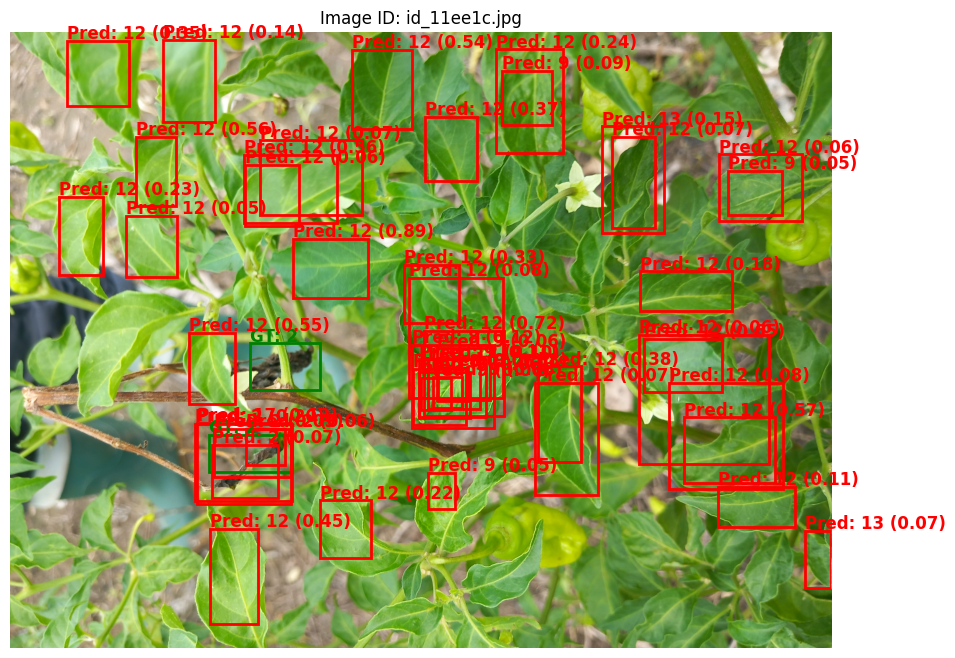

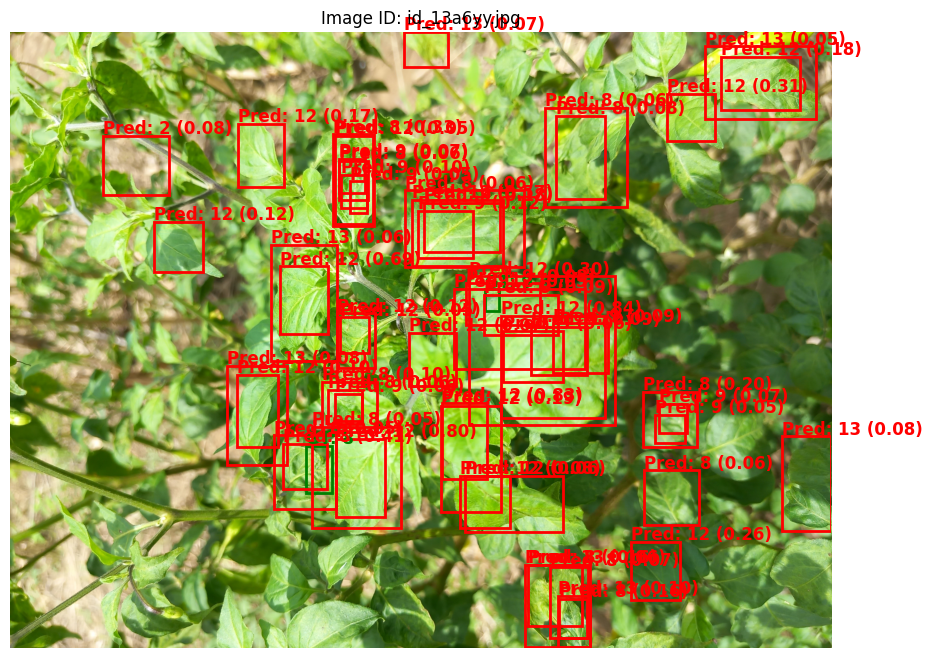

In [22]:
# Visualize predictions on 2 images
visualize_predictions(model, val_loader, device, num_images=2)

# Submission

In [23]:
class TestDataset(Dataset):
    def __init__(self, image_ids, image_dir, transforms=None):
        super().__init__()
        self.image_ids = image_ids
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        image = cv2.imread(f"{self.image_dir}/{image_id}", cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0

        if self.transforms:
            image = self.transforms(image=image)["image"]

        # Convert to tensor
        image = torch.tensor(image).permute(2, 0, 1)  # (H, W, C) -> (C, H, W)

        return image, image_id

    def __len__(self):
        return len(self.image_ids)


In [24]:
def run_inference(model, data_loader, device, score_threshold=0.5):
    model.eval()
    predictions = []

    with torch.no_grad():
        for images, image_ids in tqdm(data_loader):
            images = list(img.to(device) for img in images)

            # Perform inference
            outputs = model(images)

            for image_id, output in zip(image_ids, outputs):
                boxes = output["boxes"].cpu().numpy()
                scores = output["scores"].cpu().numpy()
                labels = output["labels"].cpu().numpy()

                image_predictions = []

                # Filter predictions based on confidence score threshold
                for box, score, label in zip(boxes, scores, labels):
                    if score >= score_threshold:
                        image_predictions.append({
                            "Image_ID": image_id,
                            "confidence": score,
                            "class": label,
                            "ymin": box[1],
                            "xmin": box[0],
                            "ymax": box[3],
                            "xmax": box[2],
                        })

                # Add at least one prediction for each image
                if not image_predictions and len(scores) > 0:
                    # Get the highest-scoring prediction
                    best_idx = scores.argmax()
                    image_predictions.append({
                        "Image_ID": image_id,
                        "confidence": scores[best_idx],
                        "class": labels[best_idx],
                        "ymin": boxes[best_idx][1],
                        "xmin": boxes[best_idx][0],
                        "ymax": boxes[best_idx][3],
                        "xmax": boxes[best_idx][2],
                    })

                # Add all valid predictions to the main list
                predictions.extend(image_predictions)

    return predictions


def save_predictions_to_csv(predictions, output_file):
    df = pd.DataFrame(predictions)
    df["class"] = df["class"].map(reverse_label_mapping)
    df.to_csv(output_file, index=False)
    print(f"Predictions saved to {output_file}")

In [25]:
test.columns

Index(['Image_ID', 'confidence', 'class', 'ymin', 'xmin', 'ymax', 'xmax'], dtype='object')

In [26]:
# Create Dataset objects with different transforms
def collate_fn(batch):
    images, image_ids = zip(*batch)
    return list(images), list(image_ids)

test_dataset = TestDataset(image_ids=test["Image_ID"].unique(), image_dir=IMG_PATH)
test_loader = DataLoader(
    test_dataset,
    batch_size=4, 
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

In [27]:
predictions = run_inference(model, test_loader, device, score_threshold=0.5)

100%|██████████| 526/526 [05:51<00:00,  1.50it/s]


In [28]:
test['Image_ID'].nunique()

2101

In [29]:
save_predictions_to_csv(predictions, "submission_fastrcnn_4f_3epoch.csv")

Predictions saved to submission_fastrcnn_4f_3epoch.csv
